In [20]:
import shutil
import os
import re

import tensorflow as tf
import os
import sys
import random
import numpy as np

from tqdm import tqdm #progress bar
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from scipy import ndimage

PATH_BENIGN = 'C:/Users/Marta/Desktop/MI Medical Image Segmentation Project/Breast Cancer Segmentation Project/data/data/benign/' #sciezki poczatkowe zanim przenieslismy pliki
PATH_MALIGNANT = 'C:/Users/Marta/Desktop/MI Medical Image Segmentation Project/Breast Cancer Segmentation Project/data/data/malignant/'
PATH_NORMAL = 'C:/Users/Marta/Desktop/MI Medical Image Segmentation Project/Breast Cancer Segmentation Project/data/data/normal/'

def check_if_folder_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)


def przenies_pliki(folder_zrodlowy):
    check_if_folder_exists(folder_zrodlowy+'images')
    check_if_folder_exists(folder_zrodlowy+'masks')

    for plik in os.listdir(folder_zrodlowy): #listuje nazwy plikow w katalogu zrodlowym, a nie sciezki
        if (not os.path.isdir(folder_zrodlowy + plik)): #jesli to na co trafilismy nie jest katalogiem -> jest plikiem
            if re.match(r'.*mask.*', plik): #regex, dopasowane wszystkie stringi ktore w srodku maja napis mask, a na lewo i prawo od napisu mask maja od 0 do nieskonczonosci dowolnych znakow
                shutil.move(folder_zrodlowy + plik, folder_zrodlowy + 'masks/' + plik) #przenosimy plik do folderu z maskami (co przenosimy, dokad)
                #print(plik)
            else:
                shutil.move(folder_zrodlowy + plik, folder_zrodlowy + 'images/' + plik) #jesli nie ma mask w srodku tzn ze to zdjecie -> przenosze do zdjecie
                

przenies_pliki(PATH_BENIGN) #wyswitlenie nazw plikow ktore maja mask w nazwie
przenies_pliki(PATH_MALIGNANT)
przenies_pliki(PATH_NORMAL)


In [2]:
PATH_TRAINING = 'C:/Users/Marta/Desktop/MI Medical Image Segmentation Project/Breast Cancer Segmentation Project/data/data/training/'
PATH_TESTING = 'C:/Users/Marta/Desktop/MI Medical Image Segmentation Project/Breast Cancer Segmentation Project/data/data/testing/'

def create_directory_structure(test_dir, train_dir):
    check_if_folder_exists(test_dir + 'benign/' + 'images')
    check_if_folder_exists(test_dir + 'malignant/' + 'images')
    check_if_folder_exists(test_dir + 'normal/' + 'images')

    check_if_folder_exists(test_dir + 'benign/' + 'masks')
    check_if_folder_exists(test_dir + 'malignant/' + 'masks')
    check_if_folder_exists(test_dir + 'normal/' + 'masks')

    check_if_folder_exists(train_dir + 'benign/' + 'images')
    check_if_folder_exists(train_dir + 'malignant/' + 'images')
    check_if_folder_exists(train_dir + 'normal/' + 'images')

    check_if_folder_exists(train_dir + 'benign/' + 'masks')
    check_if_folder_exists(train_dir + 'malignant/' + 'masks')
    check_if_folder_exists(train_dir + 'normal/' + 'masks')


create_directory_structure(PATH_TESTING, PATH_TRAINING)
    


In [3]:
def split_data(test_dir, train_dir, source_dir, split_ratio = 0.2):
    images_names = os.listdir(source_dir + 'images') #lista z nazwami imagesów ktore sa w folderze images
    images_count = len(images_names) #ile jest plikow w folderze images
    test_count = int(split_ratio * images_count) #ile z imagesow do zbioru testowego
    for i in range(0, test_count):
        random_number = random.randint(0, images_count - i) #z kazda iteracja zmniejsza sie liczba dostepnych obrazow
        images_count -= 1 #po zabraniu 1 zdjecia do zbioru testowego
        moved_image = images_names.pop(random_number) #biore nazwe zdjecia ktore chce do zbioru testowego, usuwa z dictionary zdjecie o tym ID i przypisuje to do zmiennej moved_image
        masks_to_move = [] #pusta lista, to beda maski do zbioru testowego odpowiadajace zdjeciu ktore przenieslismy do testowego
        masks_names = os.listdir(source_dir + 'masks') #mam nazwy masek: z benignow biore do listy nazwy zdjec z maskami
        pattern = moved_image.split(".")[0] #to co przed ".png", "benign (1)"
        pattern = re.escape(pattern) #ignoruje specjalne znaki wstawiajac przed nie backslashe, aby rematch nie myslal ze to special characters

        for mask in masks_names:
            if re.match(fr'{pattern}.*', mask): #regex, chce dopasowac maske do patternu, dopasowane wszystkie stringi ktore zaczynaja sie od patternu a na lewo i prawo od napisu mask maja od 0 do nieskonczonosci dowolnych znakow
                shutil.move(source_dir + 'masks/' + mask, test_dir + 'masks/' + mask) #przenosimy plik do folderu z maskami. #przenosze mas odpowiadajace 1 zdjeciu ktorych moze byc wiecej niz 1
                #print(mask + "and" + pattern )

        shutil.move(source_dir + 'images/' + moved_image, test_dir + 'images/' + moved_image)  #przenosze 1 zdjecie

    #przeniesienie treningowych masek, zdjec
    images_names = os.listdir(source_dir + 'images')
    for image in images_names:
        shutil.move(source_dir + 'images/' + image, train_dir + 'images/' + image)


    masks_names = os.listdir(source_dir + 'masks')
    for mask in masks_names:
        shutil.move(source_dir + 'masks/' + mask, train_dir + 'masks/' + mask)
            
            


split_data(PATH_TESTING + 'benign/', PATH_TRAINING + 'benign/', PATH_BENIGN) #30% benigna
split_data(PATH_TESTING + 'malignant/', PATH_TRAINING + 'malignant/', PATH_MALIGNANT)
split_data(PATH_TESTING + 'normal/', PATH_TRAINING + 'normal/', PATH_NORMAL)
    


In [4]:
seed = 37
np.random.seed = seed

img_width = 128
img_height = 128
img_channels = 3

In [5]:
def resize_images(path_to_data):
    subfolder_names = ["normal", "benign", "malignant"]
    
    normal_imgs_file_names = os.listdir(path_to_data + "normal/images")
    benign_imgs_file_names = os.listdir(path_to_data + "benign/images")
    malignant_imgs_file_names = os.listdir(path_to_data + "malignant/images")

    normal_masks_file_names = os.listdir(path_to_data + "normal/masks")
    benign_masks_file_names = os.listdir(path_to_data + "benign/masks")
    malignant_masks_file_names = os.listdir(path_to_data + "malignant/masks")

    all_img_file_names = [normal_imgs_file_names, benign_imgs_file_names, malignant_imgs_file_names]
    all_mask_file_names = [normal_masks_file_names, benign_masks_file_names, malignant_masks_file_names]

    number_of_training_imgs = len(normal_imgs_file_names) + len(benign_imgs_file_names) + len(malignant_imgs_file_names)

    #i fill matrix with zeros firstly
    #independent, images from trainng set
    X_matrix = np.zeros((number_of_training_imgs, img_height, img_width, img_channels), dtype=np.uint8) #625(liczba zdjec w zbiorze uczacym)*128*128*3

    #dependent, what i try to predict. 1 is bool (yes or no). Masks from training set
    #idk but i guess that 3 will be for 3 classes normal, benign and malignant
    Y_matrix = np.zeros((number_of_training_imgs, img_height, img_width, 3), dtype=bool)
    print(Y_matrix.shape)
    print('Resizing training images and masks')

    counter = 0
    for class_id, subfolder in enumerate(subfolder_names): #class id aby odpowiednie subfoldery mialy liczby 0,1,2
        current_imgs_file_names = all_img_file_names[class_id] #wszystkie nazwy zdjec np z benign
        current_masks_file_names = all_mask_file_names[class_id]

        for img_file_name in tqdm(current_imgs_file_names): #tqdm -> pasek postepu
            path = path_to_data + f"{subfolder}/images/" + img_file_name #iterujemy po plikach np w benign
            img = imread(path)[:,:,:img_channels] #wczytuje obrazek, tensor z wymiarami zdjecia = 3 channele RGB
            img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
            X_matrix[counter] = img #all images, macierz tensorow/obrazkow
            
            
            mask = np.zeros((img_height, img_width, 3), dtype=bool) #maska robocza uzupelniona zerami 3 KLASY, tensor o takich wymiarach, wszystkie komorki ustwiam na zero
            pattern = img_file_name.split(".")[0] #np benign (1)
            pattern = re.escape(pattern) #nie traktowal nawiasow jako special character
            corresponding_masks = [curr_mask for curr_mask in current_masks_file_names if re.match(fr'{pattern}.*', curr_mask)] #dodaj curr_mask do listy jesli spelnia warunki    

            for mask_file in corresponding_masks:
                mask_ = imread(path_to_data + f'{subfolder}/masks/' + mask_file, as_gray=True) #wczytanie maski w skali szarosci

                mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',  #resize do 128x128 i dodanie 3 kanału
                                             preserve_range=True), axis=-1)
                
                mask_ = np.repeat(mask_, repeats=3, axis=-1)    #dodaje 3 channele aby odpowiadaly klasom, powtarza to zrobienie 128x128x3
                mask_ = mask_.astype("bool")                    
                #powyzej kazdy z 3 kanalow jest taki sam jak maska
                # #mask_[:,:,1] = 0.5
                # print(mask_file, np.unique(mask_[:,:,1], return_counts=True))
                mask = np.maximum(mask, mask_)  #merging masks to get 1 mask. At every pixel i look for max value, take this value and create a mask
            # print("\n\n\n",np.unique(mask[:,:,1], return_counts=True))
            mask = mask.astype("float")
            #polaczone maski na 3 kanale i powtorzylismy go 3 razy. w ponizszych ifach kazda warstwa odpowiada danej klasie
            if(class_id == 0): #normal, maski w normalu czarne, wszedzie zera
                mask[:,:,0] = 1 - mask[:,:,0] #byly zera, a my chcemy aby w danych pikselach normala byly 1
            elif(class_id == 1): #chcemy aby kanal odpowiadal klasie benign
                mask[:,:,2] = 0 #to co w benignie jest jako maska to znaczy ze maska malignanta wyzerowana dla tego imagesa
                mask[:,:,0] = 1 - mask[:,:,0] #maska w warstwie normal (0) wynosi zero dla tych pikseli co dla benigna bylo 1
            else:
                mask[:,:,1] = 0 ##to co w malignancie jest jako maska to znaczy ze maska benigna wyzerowana dla tego imagesa
                mask[:,:,0] = 1 - mask[:,:,0]

            Y_matrix[counter] = mask
            counter+=1
    return X_matrix, Y_matrix #lista tensorow 128*128*3
# train_ids = next(os.walk(train_path))[1] #name of folder with train data
# test_ids = next(os.walk(test_path))[1]
#start from [1] bc otherwise it would be name stage1_train



X_train, Y_train = resize_images(PATH_TRAINING)
X_test, Y_test = resize_images(PATH_TESTING)

(625, 128, 128, 3)
Resizing training images and masks


100%|██████████| 168/168 [00:12<00:00, 14.00it/s]


(155, 128, 128, 3)
Resizing training images and masks


100%|██████████| 42/42 [00:02<00:00, 15.64it/s]


In [6]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((625, 128, 128, 3),
 (625, 128, 128, 3),
 (155, 128, 128, 3),
 (155, 128, 128, 3))

In [8]:
#building U-net model

#encoder path
#first layer
inputs = tf.keras.layers.Input((img_width, img_height, img_channels)) #128*128*3

#convert pixel into floating point number bc keras layers deal with floating numbers
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#convolutional layers
#padding=same to have the same output image size as input
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s) 
#kernel_initializer to start with some weights,
#he_normal does it by truncated normal distribution (centered around zero)


#drop 10% pixels
c1 = tf.keras.layers.Dropout(0.1)(c1)

#second convolutional layer
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1) 
#kernel_initializer to start with some weights, he_normal does it by truncated normal distribution (centered around zero)


#max pooling
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

###
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

#decoder path

#Conv2DTranspose is opposite to Conv2D
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1,1), activation='softmax')(c9) #warstwa konwolucyjna, ma 3 filtry bo 3 klasy, wymiary 1*1

#optimizer tries to minimize loss function, accuracy to measure model's performance after training
#adam works like backpropagation to train model, can also be stochastic gradient descent
#loss=binary_crossentropy bc pixel belongs to mask or not
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,248 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │      9,248 │ dropout_3[0][0] 

 Total params: 593,171 (2.26 MB)

 Trainable params: 593,171 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_breast_cancer_segmentation.keras', verbose=1, save_best_only=True)
#monituruje postep modelu i zapisuje do pliku. verbose = 1 oznacza, ze podczas zapisywania modelu bedzie wyswietlany komunikat
#save_best_only aby zapisac najlepszą wersję modelu


#trening zatrzymany po 2 kolejnych epokach, w których wartość val_loss (strat walidacyjnych) nie ulegnie poprawie. 
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss'), #chce monitorowac funkcje celu dla trenujacego -> sprawdza ile jest epok i gdy funkcja celu sie nie zmniejsza przez 2-3 epoki z rzedu -> konczy uczenie modelu
    tf.keras.callbacks.TensorBoard(log_dir='logs') #to create logs
]

#training model
results = model.fit(X_train, Y_train, batch_size=32, epochs=25, callbacks=callbacks) #batch_size ile zdjec daje przy jednej iteracji

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8524 - loss: 0.6301
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9218 - loss: 0.3173
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step - accuracy: 0.9197 - loss: 0.2780
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9156 - loss: 0.2815
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9206 - loss: 0.2595
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9206 - loss: 0.2607
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 986ms/step - accuracy: 0.9231 - loss: 0.2480
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 964ms/step - accuracy: 0.9217 - loss: 0.2498
Epoch 9/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 975ms/step - accuracy: 0.9191 - loss: 0.2509
Epoch 10/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9135 - loss: 0.2527
Epoch 11/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 957ms/step - accuracy: 0.9249 - loss: 0.2181
Epoch 12/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 984ms/step - acc

In [11]:
preds_train = model.predict(X_train, verbose=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


### wyświetlanie losowo wybranych zdjęć ze zbioru trenującego

C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\3654610339.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3) #aby byly stale kolory dla danych klas
C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\3654610339.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  magnitude *= 255 / np.max(magnitude) # Normalization
C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\3654610339.py:47: RuntimeWarning: invalid value encountered in multiply
  magnitude *= 255 / np.max(magnitude) # Normalization


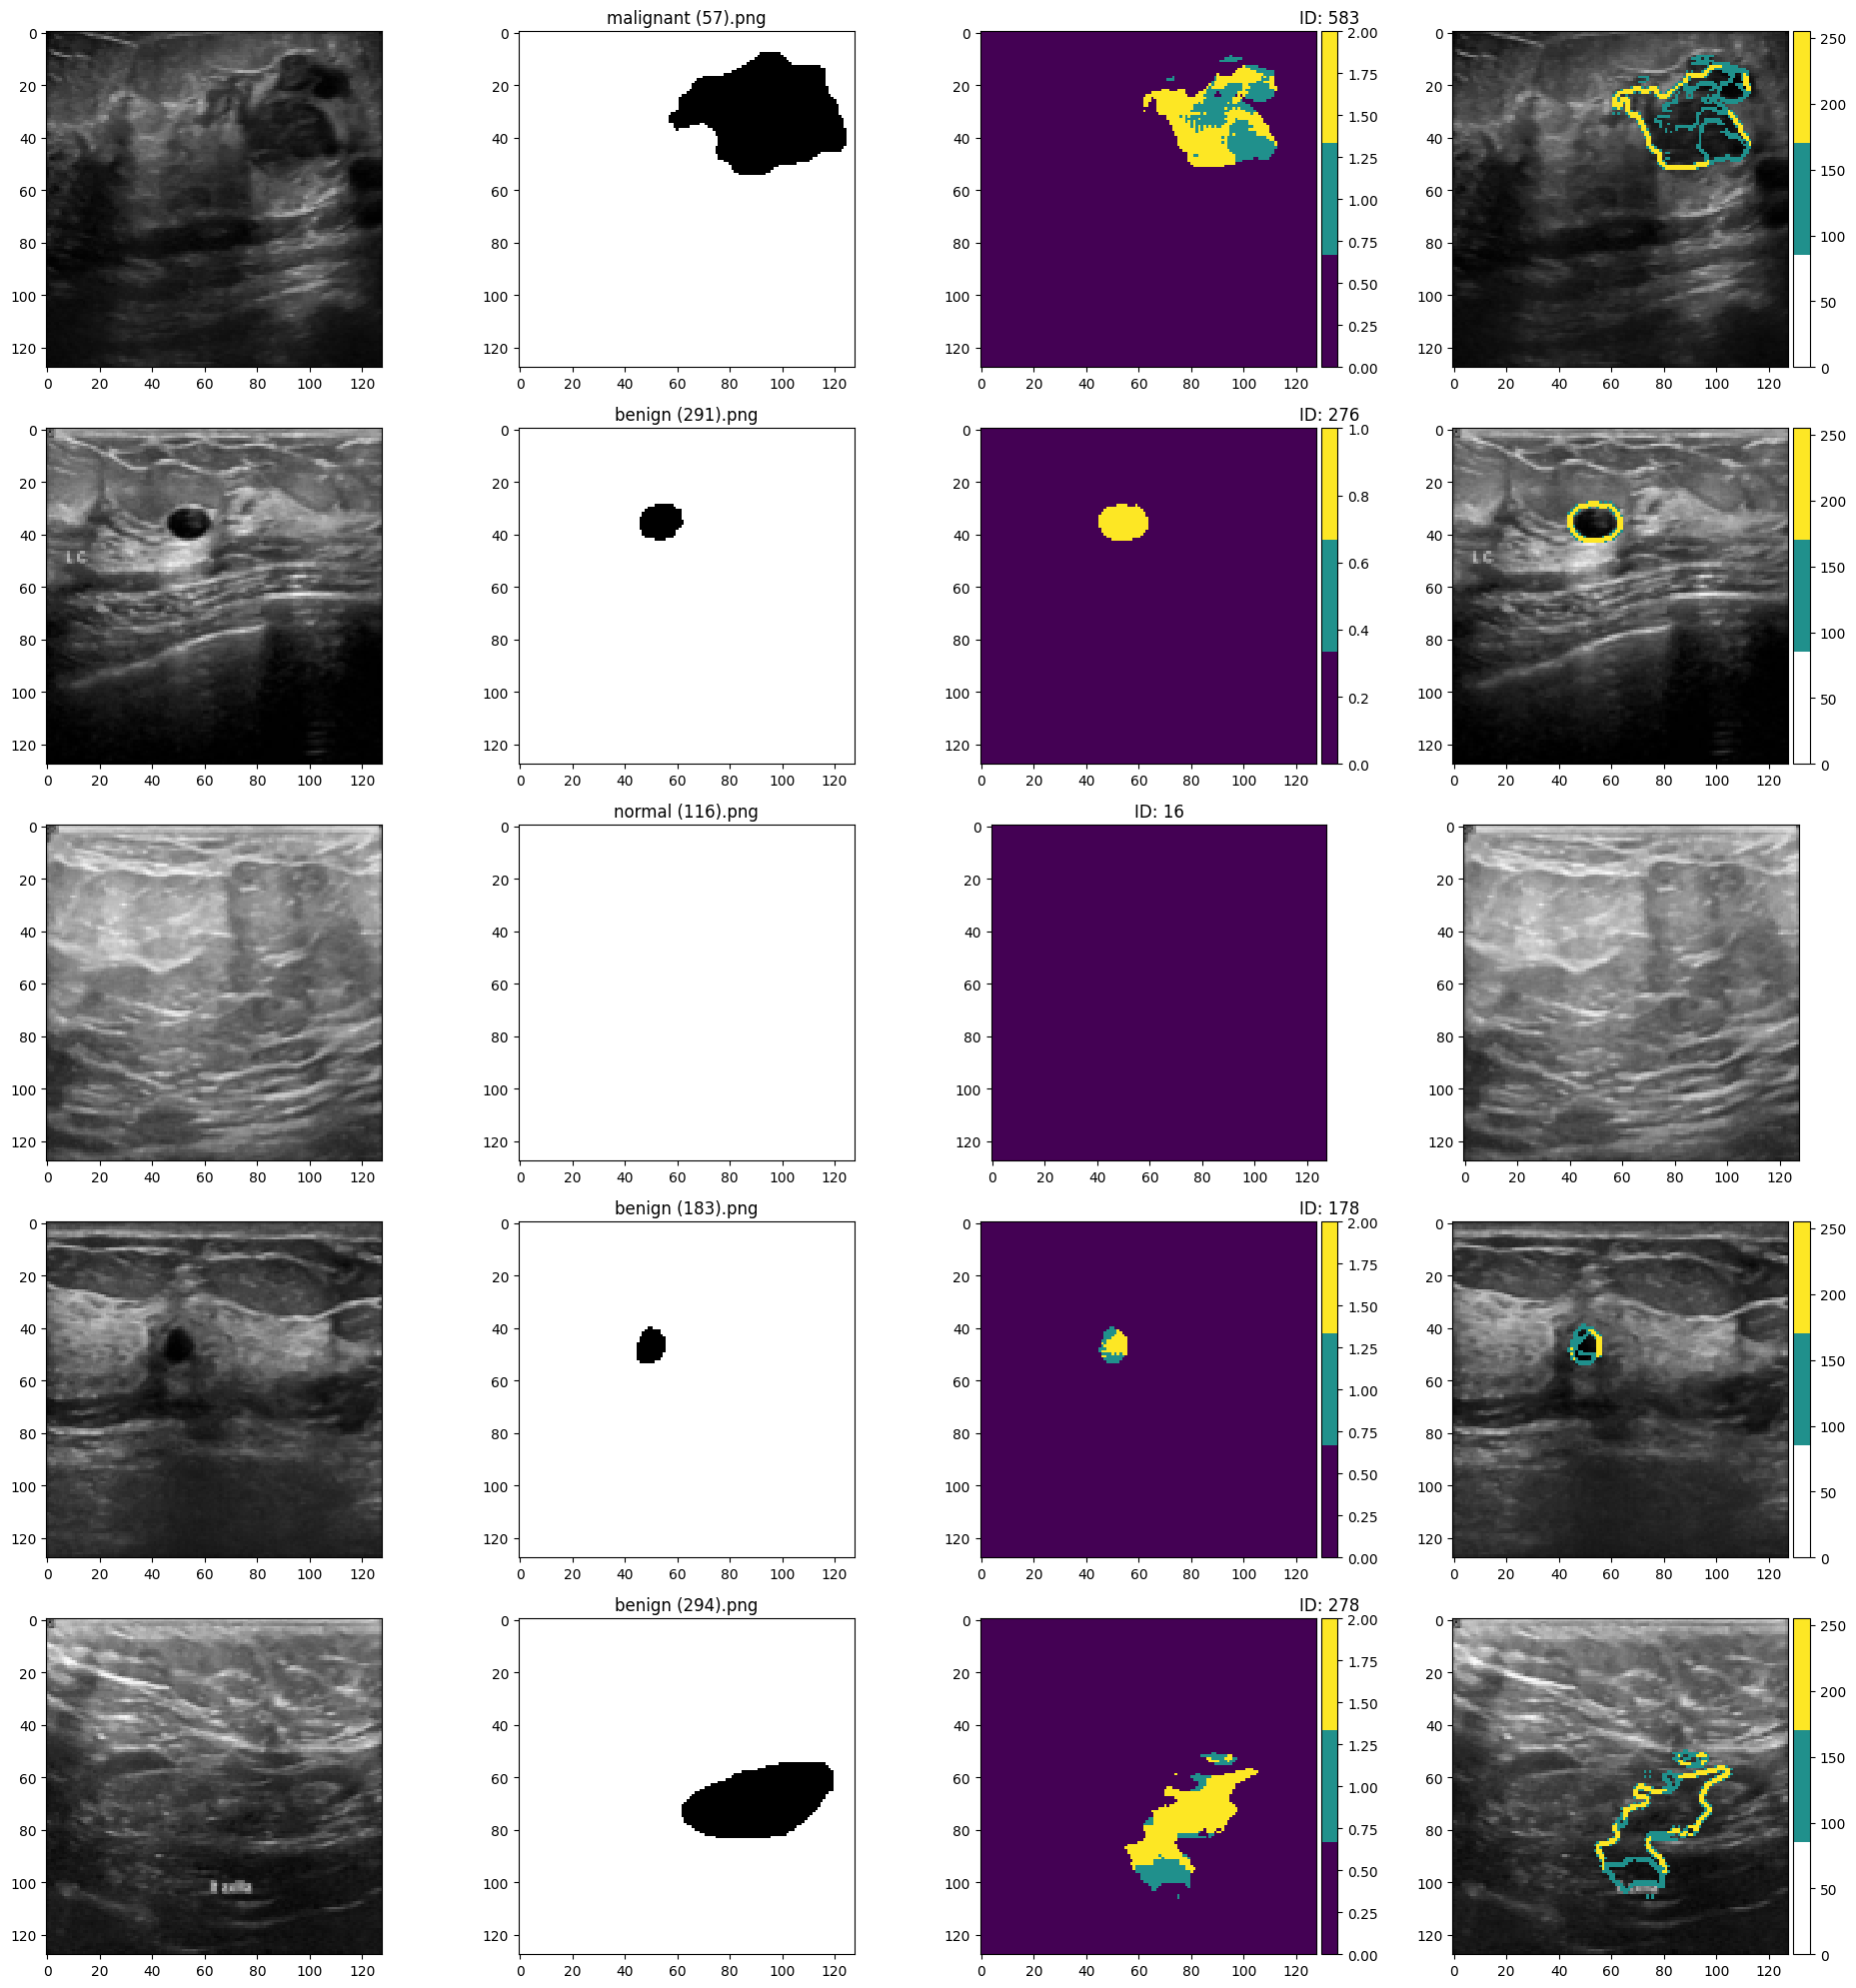

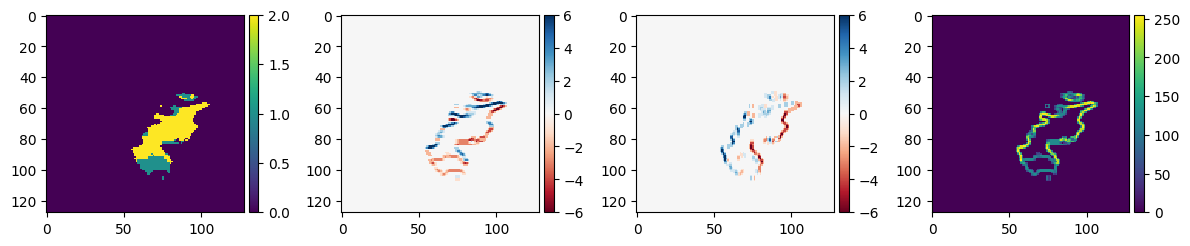

In [40]:
images_normal_names = os.listdir(PATH_TRAINING + 'normal/' + 'images')
images_benign_names = os.listdir(PATH_TRAINING + 'benign/' + 'images')
images_malignant_names = os.listdir(PATH_TRAINING + 'malignant/' + 'images')

all_images_names = []
all_images_names.extend(images_normal_names)
all_images_names.extend(images_benign_names)
all_images_names.extend(images_malignant_names)

random_numbers = []
number_of_images_to_visualize = 5
for i in range (number_of_images_to_visualize):
    random_numbers.append(random.randint(0, len(all_images_names)))

plt.figure(figsize=(20,20))

colors = [(0, 0, 0, 0),  # Przezroczysty
          (0.12549, 0.56471, 0.54902, 1),  # Zielony
          (0.99216, 0.90588, 0.14509, 1)]  # Żółty
cmap_name = 'custom_cmap'
custom_cmap = ListedColormap(colors)

for i, number in enumerate(random_numbers):
    plt.subplot(number_of_images_to_visualize, 4, i*4 + 1) #(liczba wierszy, kolumn, ktory obraz) ||| numer zdjecia ktory bedzie teraz deklarowany, 1 bo pierwszy
    imshow(X_train[number])

    plt.subplot(number_of_images_to_visualize, 4, i*4 + 2)
    imshow(Y_train[number][:,:,0]) #wyswietla sie oryginalna maska dla normala, do klasy 0 nalezą biale piksele, normal zawsze otacza i benigna i malignanta wiec zawsze dobra maska
    plt.title(all_images_names[number])

    plt.subplot(number_of_images_to_visualize, 4, i*4 + 3)
    prediction = preds_train[number] #lista obrazow: liczba wierszy * liczba kolumn * liczba klas (3 klasy) -> 128*128*3 
    prediction = np.argmax(prediction, axis = 2) #axis = 2 oznacza ze biore maksymalną trzeciego wymiaru 
    cmap = plt.cm.get_cmap('viridis', 3) #aby byly stale kolory dla danych klas
    imshow(prediction, cmap=cmap) #||cmap = cmap czyli mapa kolorow to mapa kolorow

    plt.title("ID: " + str(number))

    plt.subplot(number_of_images_to_visualize, 4, i*4 + 4)

    prewitt_h = ndimage.prewitt(prediction, axis=0) #filtr prewitta na moich predykcjach, horyzontalny
    # obliczanie gradientu pionowego, co pozwala na wykrycie zmian jasności w pionowym kierunku
    prewitt_v = ndimage.prewitt(prediction, axis=1)
    magnitude = np.sqrt(prewitt_h ** 2 + prewitt_v ** 2)
    #magnituda gradientu polega na obliczeniu pierwiastka kwadratowego z sumy kwadratów gradientów w obu kierunkach
    #Wynikowa macierz magnitude będzie reprezentować intensywność gradientu krawędzi w każdym punkcie obrazu
    magnitude *= 255 / np.max(magnitude) # Normalization
    #normalizuje wynikową magnitudę gradientu do przedziału od 0 do 255, aby obraz wyswietlony w skali szarości.
    imshow(X_train[number])
    imshow(magnitude, cmap=custom_cmap)

plt.show()
plt.figure(figsize=(12,12))
plt.subplot(1, 4, 1)
imshow(prediction)

plt.subplot(1, 4, 2) 
imshow(prewitt_h)#krawedzie wyszukuje w plaszczyznie poziomej

plt.subplot(1, 4, 3)
imshow(prewitt_v) #krawedzie wyszukuje w plaszczyznie pionowej

plt.subplot(1, 4, 4)
imshow(magnitude)#square root z sumy kwadratow vertical i horizontal

### wyświetlanie wybranych zdjęć ze zbioru trenującego

C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\1040247309.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3) #aby byly stale kolory dla danych klas
C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\1040247309.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  magnitude *= 255 / np.max(magnitude) # Normalization
C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\1040247309.py:24: RuntimeWarning: invalid value encountered in multiply
  magnitude *= 255 / np.max(magnitude) # Normalization


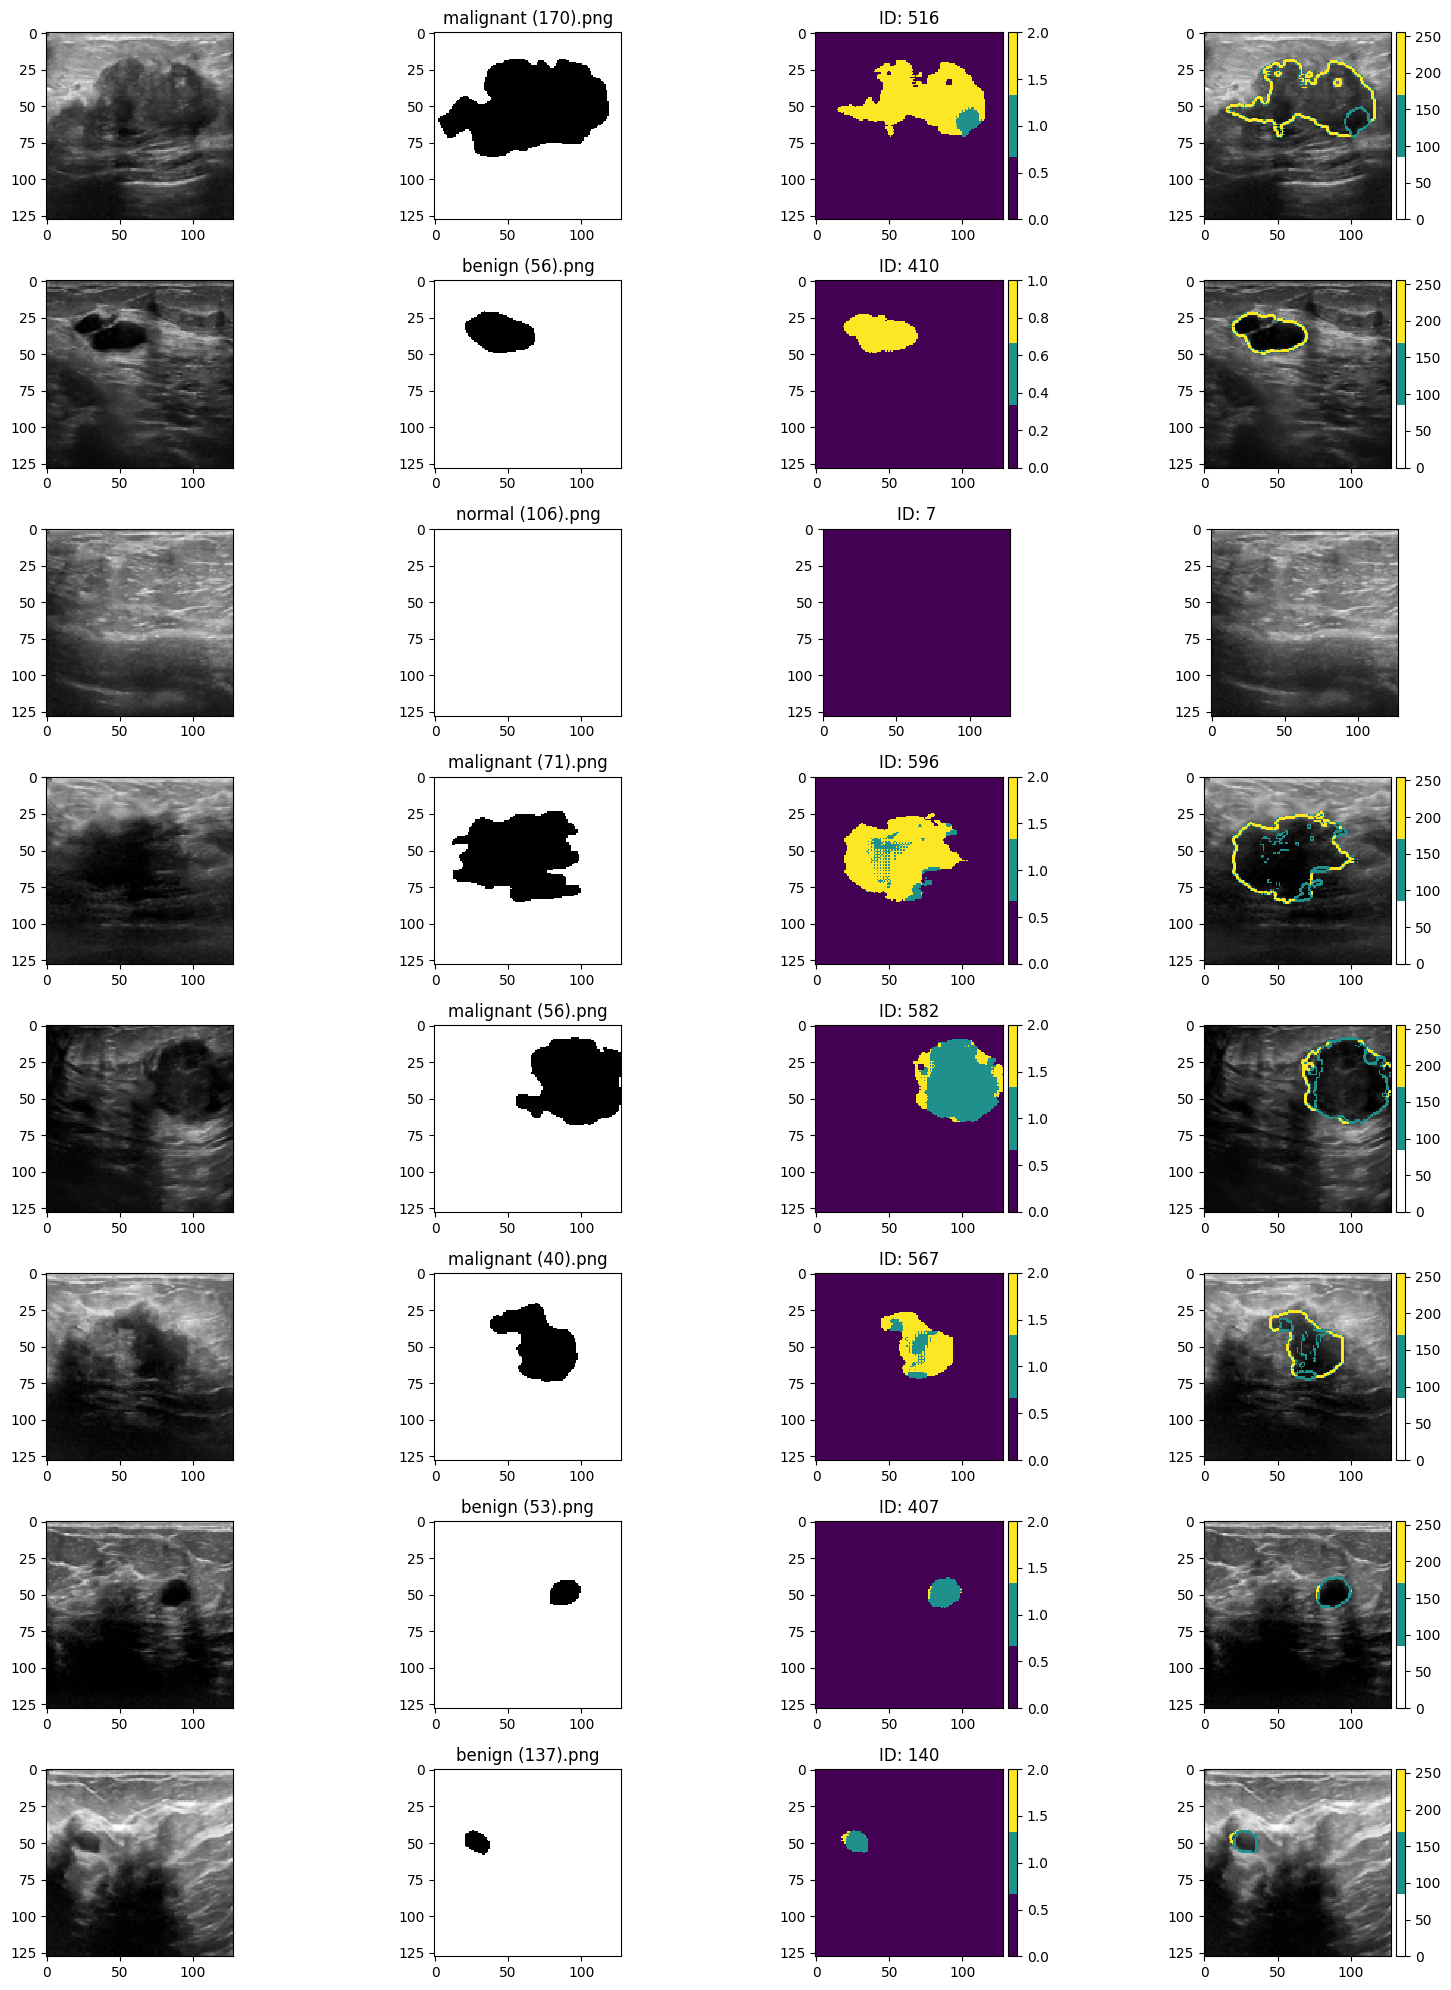

In [56]:
IDs_to_show = [516, 410, 7, 596, 582, 567, 407, 140]
plt.figure(figsize=(20,20))

for i, number in enumerate(IDs_to_show):
    plt.subplot(len(IDs_to_show), 4, i*4 + 1) #(liczba wierszy, kolumn, ktory obraz) ||| numer zdjecia ktory bedzie teraz deklarowany, 1 bo pierwszy
    imshow(X_train[number])

    plt.subplot(len(IDs_to_show), 4, i*4 + 2)
    imshow(Y_train[number][:,:,0]) #wyswietla sie oryginalna maska dla normala, do klasy 0 nalezą biale piksele, normal zawsze otacza i benigna i malignanta wiec zawsze dobra maska
    plt.title(all_images_names[number])

    plt.subplot(len(IDs_to_show), 4, i*4 + 3)
    plt.title("ID: " + str(number))
    prediction = preds_train[number] #lista obrazow: liczba wierszy * liczba kolumn * liczba klas (3 klasy) -> 128*128*3 
    prediction = np.argmax(prediction, axis = 2) #axis = 2 oznacza ze biore maksymalną trzeciego wymiaru 
    cmap = plt.cm.get_cmap('viridis', 3) #aby byly stale kolory dla danych klas
    imshow(prediction, cmap=cmap) #||cmap = cmap czyli mapa kolorow to mapa kolorow

    plt.subplot(len(IDs_to_show), 4, i*4 + 4)

    prewitt_h = ndimage.prewitt(prediction, axis=0) #filtr prewitta na moich predykcjach, horyzontalny
    prewitt_v = ndimage.prewitt(prediction, axis=1)
    magnitude = np.sqrt(prewitt_h ** 2 + prewitt_v ** 2)
    magnitude *= 255 / np.max(magnitude) # Normalization
    imshow(X_train[number])
    imshow(magnitude, cmap=custom_cmap)


In [55]:
for id, nazwa in enumerate(all_images_names):
    if(nazwa == 'benign (137).png'):
        print(id)
        break

140


In [32]:
test_results = model.predict(X_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


### zbiór testowy

In [105]:
images_normal_names_test = os.listdir(PATH_TESTING + 'normal/' + 'images')
images_benign_names_test = os.listdir(PATH_TESTING + 'benign/' + 'images')
images_malignant_names_test = os.listdir(PATH_TESTING + 'malignant/' + 'images')

all_images_names_test = []
all_images_names_test.extend(images_normal_names_test)
all_images_names_test.extend(images_benign_names_test)
all_images_names_test.extend(images_malignant_names_test)

random_numbers_test = []
number_of_images_to_visualize_test = 5
for i in range (number_of_images_to_visualize_test): #Losuje numery indeksów obrazów do wizualizacji. 
    random_numbers_test.append(random.randint(0, len(all_images_names_test)))



### wyświetlanie wybranych zdjęć ze zbioru testowego

C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\2554858404.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3) #aby byly stale kolory dla danych klas
C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\2554858404.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  magnitude *= 255 / np.max(magnitude) # Normalization
C:\Users\Marta\AppData\Local\Temp\ipykernel_12932\2554858404.py:25: RuntimeWarning: invalid value encountered in multiply
  magnitude *= 255 / np.max(magnitude) # Normalization


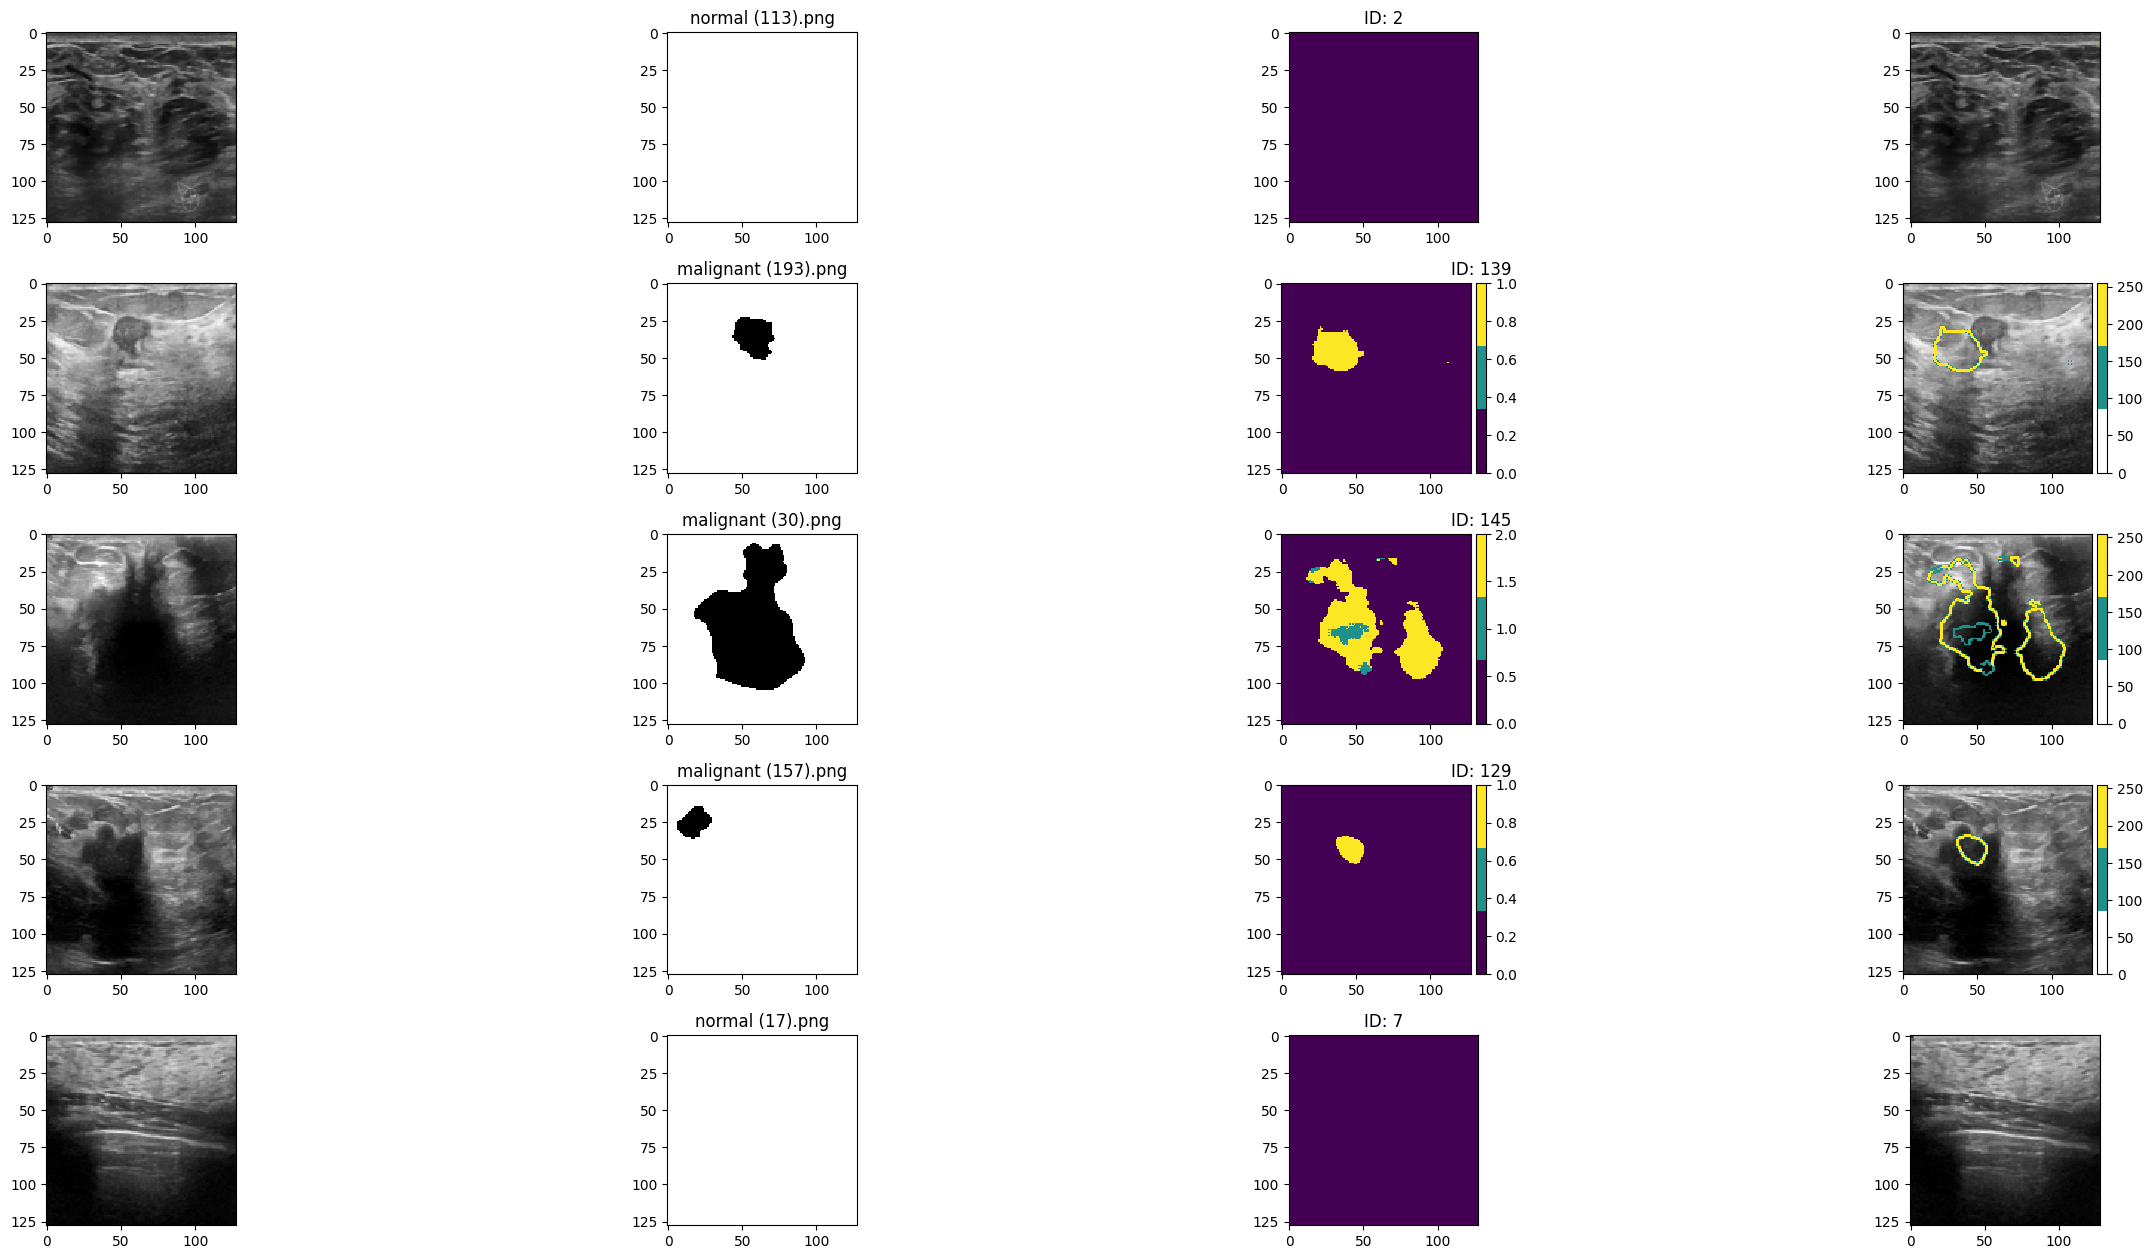

In [93]:
plt.figure(figsize=(25, 25))
IDs_to_show_test = [2, 139, 145, 129, 7]

for i, number in enumerate(IDs_to_show_test):
    plt.subplot(number_of_images_to_visualize_test, 4, i*4 + 1) #(liczba wierszy, kolumn, ktory obraz) ||| numer zdjecia ktory bedzie teraz deklarowany, 1 bo pierwszy
    imshow(X_test[number])

    plt.subplot(number_of_images_to_visualize_test, 4, i*4 + 2)
    imshow(Y_test[number][:,:,0]) #wyswietla sie oryginalna maska dla normala, do klasy 0 nalezą biale piksele, normal zawsze otacza i benigna i malignanta wiec zawsze dobra maska
    plt.title(all_images_names_test[number])

    plt.subplot(number_of_images_to_visualize_test, 4, i*4 + 3)
    prediction = preds_train[number] #lista obrazow: liczba wierszy * liczba kolumn * liczba klas (3 klasy) -> 128*128*3 
    prediction = np.argmax(prediction, axis = 2) #axis = 2 oznacza ze biore maksymalną trzeciego wymiaru 
    cmap = plt.cm.get_cmap('viridis', 3) #aby byly stale kolory dla danych klas
    imshow(prediction, cmap=cmap) #||cmap = cmap czyli mapa kolorow to mapa kolorow

    plt.title("ID: " + str(number))

    plt.subplot(number_of_images_to_visualize_test, 4, i*4 + 4)

    prewitt_h = ndimage.prewitt(prediction, axis=0) #filtr prewitta na moich predykcjach, horyzontalny
    prewitt_v = ndimage.prewitt(prediction, axis=1)
    magnitude = np.sqrt(prewitt_h ** 2 + prewitt_v ** 2)
    magnitude *= 255 / np.max(magnitude) # Normalization
    imshow(X_test[number])
    imshow(magnitude, cmap=custom_cmap)